In [11]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'
agent_to_id = {
    # 'RL': 385,
    
    # # 5 'small' graphs (image classification and NMT) -> 1000 in an episode (replication_factor=200)
    # 'RL-JCT': 437, # reward=lookahead_job_completion_time
    # 'RL-Acc': 440, # reward=job_acceptance
    
    
    
    
    # RAMP_JOB_PARTITIONING
    
    # 200 AlexNet, max_partitions_per_op=None
    # 'RL\n(JCT)': 104,
    # 'RL\n(Acc)': 103,
    
    'FRF-1': 207,
    'FRF-10': 209,
    'FRF-100': 208,
    
    
}

In [18]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
    'return',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

# episode_metrics = set()
# step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    if os.path.isdir(agent_dir+'checkpoints/'):
        print(f'\nLoading checkpoints from {agent_dir[:-1]}...')
        
        # get paths to checkpoints
        checkpoint_dirs = sorted(glob.glob(agent_dir+'checkpoints/*'))
        
        # load stats at each checkpoint
        for checkpoint_dir in checkpoint_dirs[:-1]:
            checkpoint = int(checkpoint_dir.split('/')[-1].split('_')[-1])
            
            completion_stats_found, blocked_stats_found = False, False
            
            # load episode stats
            with gzip.open(checkpoint_dir+'/episode_stats.pkl', 'rb') as f:
                episode_stats = pickle.load(f)
            for metric, result in episode_stats.items():
                if metric in episode_metrics:
                    try:
                        agent_to_episode_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_stats_dict[metric].append(result)
                elif metric in episode_completion_metrics:
                    completion_stats_found = True
                    try:
                        agent_to_episode_completion_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_completion_stats_dict[metric].append(result)
                elif metric in episode_blocked_metrics:
                    blocked_stats_found = True
                    try:
                        agent_to_episode_blocked_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_blocked_stats_dict[metric].append(result)
                else:
                    raise Exception(f'Unrecognised metric {metric}')
            agent_to_episode_stats_dict['Agent'].append(agent)
            agent_to_episode_stats_dict['Checkpoint'].append(checkpoint)
            if completion_stats_found:
                agent_to_episode_completion_stats_dict['Agent'].append(agent)
                agent_to_episode_completion_stats_dict['Checkpoint'].append(checkpoint)
            if blocked_stats_found:
                agent_to_episode_blocked_stats_dict['Agent'].append(agent)
                agent_to_episode_blocked_stats_dict['Checkpoint'].append(checkpoint)
                
            # load step stats
            with gzip.open(checkpoint_dir+'/step_stats.pkl', 'rb') as f:
                step_stats = pickle.load(f)
            for metric, result in step_stats.items():
                try:
                    agent_to_step_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_step_stats_dict[metric].append(result)
                step_metrics.add(metric)
            agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
            agent_to_step_stats_dict['Checkpoint'].extend([checkpoint for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading checkpoints from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_207...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_207.

Loading checkpoints from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_209...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_209.

Loading checkpoints from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_208...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_208.

Episode stats:


return  num_jobs_arrived  num_jobs_completed  num_jobs_blocked  \
0    -81.093459             100.0                38.0              62.0   
1    -72.052492             100.0                83.0              17.0   
2    -68.569972             100.0                89.0              11.0   
3   -100.000000             100.0                 0.0             100.0   
4   -100.000000             100.0                 0.0             100.0   
..          ...               ...                 ...               ...   
295   -4.960000             100.0                96.0               4.0   
296   -4.960000             100.0                96.0               4.0   
297   -1.990000             100.0                99.0               1.0   
298   -5.950000             100.0                95.0               5.0   
299   -1.990000             100.0                99.0               1.0   

       Agent  Checkpoint  
0      FRF-1           0  
1      FRF-1           1  
2      FRF-1           2  
3      FRF-1           3  
4      FRF-1           4  
..       ...         ...  
295  FRF-100          95  
296  FRF-100          96  
297  FRF-100          97  
298  FRF-100          98  
299  FRF-100          99  

[300 rows x 6 columns]

job_completion_time  job_communication_overhead_time  \
0            4798.526191                      4798.526191   
1           17929.104308                     17929.104308   
2           17473.595495                     17473.595495   
3           29751.848969                     29751.848969   
4           30657.327604                     30657.327604   
..                   ...                              ...   
287         30693.523438                     30693.523438   
288         30031.191146                     30031.191146   
289         29883.382323                     29883.382323   
290         29938.768421                     29938.768421   
291         29898.895455                     29898.895455   

     job_computation_overhead_time  jobs_completed_num_nodes  \
0                      4709.220317                284.052632   
1                     17929.104308                173.373494   
2                     17473.595495                176.359551   
3                     29751.848969                100.783505   
4                     30657.327604                100.166667   
..                             ...                       ...   
287                   30693.523438                100.729167   
288                   30031.191146                100.458333   
289                   29883.382323                100.949495   
290                   29938.768421                 99.389474   
291                   29898.895455                100.585859   

     jobs_completed_num_edges  jobs_completed_total_operation_memory_cost  \
0                 2435.500000                                4.938145e+09   
1                  404.156627                                1.619345e+10   
2                  415.494382                                1.557819e+10   
3                  112.340206                                1.553187e+10   
4                  111.208333                                1.597039e+10   
..                        ...                                         ...   
287                111.937500                                1.591140e+10   
288                111.916667                                1.538170e+10   
289                112.454545                                1.577959e+10   
290                110.621053                                1.550265e+10   
291                112.090909                                1.550101e+10   

     jobs_completed_total_dependency_size    Agent  Checkpoint  
0                            1.936197e+10    FRF-1           0  
1                            2.414005e+10    FRF-1           1  
2                            2.386764e+10    FRF-1           2  
3                            1.659345e+10    FRF-1           7  
4                            1.701145e+10    FRF-1           8  
..                                    ...      ...         ...  
287                          1.698381e+10  FRF-100          95  
288                          1.644359e+10  FRF-100          96  
289                          1.684908e+10  FRF-100          97  
290                          1.654216e+10  FRF-100          98  
291                          1.656965e+10  FRF-100          99  

[292 rows x 9 columns]

jobs_blocked_num_nodes  jobs_blocked_num_edges  \
0                119.096774              131.709677   
1                103.647059              116.882353   
2                103.818182              116.090909   
3                100.400000              111.800000   
4                100.400000              111.800000   
..                      ...                     ...   
278               92.500000              108.500000   
279               99.000000              109.000000   
280               46.000000               47.000000   
281              119.600000              134.200000   
282               82.000000               83.000000   

     jobs_blocked_total_operation_memory_cost  \
0                                2.221896e+10   
1                                1.300995e+10   
2                                1.625146e+10   
3                                1.565225e+10   
4                                1.565225e+10   
..                                        ...   
278                              9.432660e+09   
279                              2.214542e+10   
280                              3.046234e+09   
281                              1.849474e+10   
282                              3.062530e+10   

     jobs_blocked_total_dependency_size    Agent  Checkpoint  
0                          2.323131e+10    FRF-1           0  
1                          1.352003e+10    FRF-1           1  
2                          1.618334e+10    FRF-1           2  
3                          1.591208e+10    FRF-1           3  
4                          1.591208e+10    FRF-1           4  
..                                  ...      ...         ...  
278                        8.137615e+09  FRF-100          95  
279                        2.196800e+10  FRF-100          96  
280                        2.422161e+09  FRF-100          97  
281                        1.917430e+10  FRF-100          98  
282                        2.946706e+10  FRF-100          99  

[283 rows x 6 columns]


Step stats:


action    reward  step_counter  step_start_time  \
0           4 -1.000000             0              0.0   
1           6 -1.000000             1           1000.0   
2           8 -0.137369             2           2000.0   
3           6 -1.000000             3           3000.0   
4           8 -0.137369             5           4000.0   
...       ...       ...           ...              ...   
29995       1 -0.010000           162          95000.0   
29996       1 -0.010000           163          96000.0   
29997       1 -0.010000           164          97000.0   
29998       1 -0.010000           166          98000.0   
29999       1 -0.010000           197          99000.0   

       mean_num_mounted_workers  mean_num_mounted_channels  \
0                           1.0                        0.0   
1                           1.0                        0.0   
2                           9.0                       56.0   
3                           9.0                       56.0   
4                          16.5                      112.0   
...                         ...                        ...   
29995                      29.0                        0.0   
29996                      29.0                        0.0   
29997                      30.0                        0.0   
29998                      30.5                        0.0   
29999                      16.0                        0.0   

       mean_compute_throughput  mean_comm_throughput  mean_cluster_throughput  \
0                 5.297591e+05          1.060823e+06             1.590582e+06   
1                 5.297591e+05          1.060823e+06             1.590582e+06   
2                 1.144703e+06          3.730998e+06             4.875701e+06   
3                 1.144703e+06          3.730998e+06             4.875701e+06   
4                 1.494768e+06          5.870761e+06             7.365529e+06   
...                        ...                   ...                      ...   
29995             1.568562e+07          1.656098e+07             3.224661e+07   
29996             1.559587e+07          1.668557e+07             3.228144e+07   
29997             1.612563e+07          1.742743e+07             3.355305e+07   
29998             1.668421e+07          1.794561e+07             3.462982e+07   
29999             8.821950e+06          9.318436e+06             1.814039e+07   

       mean_compute_overhead_frac  ...  mean_mounted_worker_utilisation_frac  \
0                             1.0  ...                              1.000000   
1                             1.0  ...                              1.000000   
2                             1.0  ...                              0.954980   
3                             1.0  ...                              0.954980   
4                             1.0  ...                              0.924966   
...                           ...  ...                                   ...   
29995                         1.0  ...                              1.000000   
29996                         1.0  ...                              1.000000   
29997                         1.0  ...                              1.000000   
29998                         1.0  ...                              1.000000   
29999                         1.0  ...                              1.000000   

       mean_cluster_worker_utilisation_frac  num_jobs_completed  \
0                                  0.031250                   0   
1                                  0.031250                   0   
2                                  0.268588                   0   
3                                  0.268588                   0   
4                                  0.477170                   1   
...                                     ...                 ...   
29995                              0.906250                   2   
29996                              0.906250                   0   
29997                       

In [19]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

xaxis = 'Checkpoint'

legend = 'auto'

def lineplot(df, metric):
    min_idx, min_val, max_idx, max_val = np.argmin(df[metric]), np.min(df[metric]), np.argmax(df[metric]), np.max(df[metric])
    min_checkpoint, max_checkpoint = df['Checkpoint'][min_idx], df['Checkpoint'][max_idx]
    print(f'Metric {metric} -> Min val: {min_val} | Min idx: {min_idx} | Min checkpoint: {min_checkpoint} || Max val: {max_val} | Max idx: {max_idx} | Max checkpoint: {max_checkpoint}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    # g = sns.scatterplot(data=df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Metric num_jobs_blocked -> Min val: 0.0 | Min idx: 15 | Min checkpoint: 15 || Max val: 100.0 | Max idx: 3 | Max checkpoint: 3


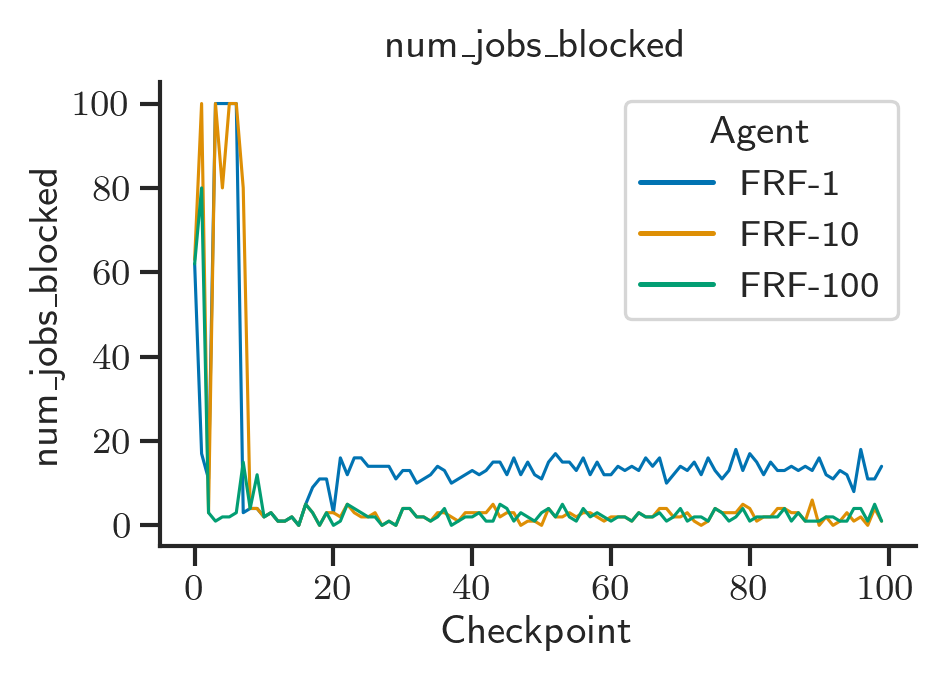

Metric num_jobs_completed -> Min val: 0.0 | Min idx: 3 | Min checkpoint: 3 || Max val: 100.0 | Max idx: 15 | Max checkpoint: 15


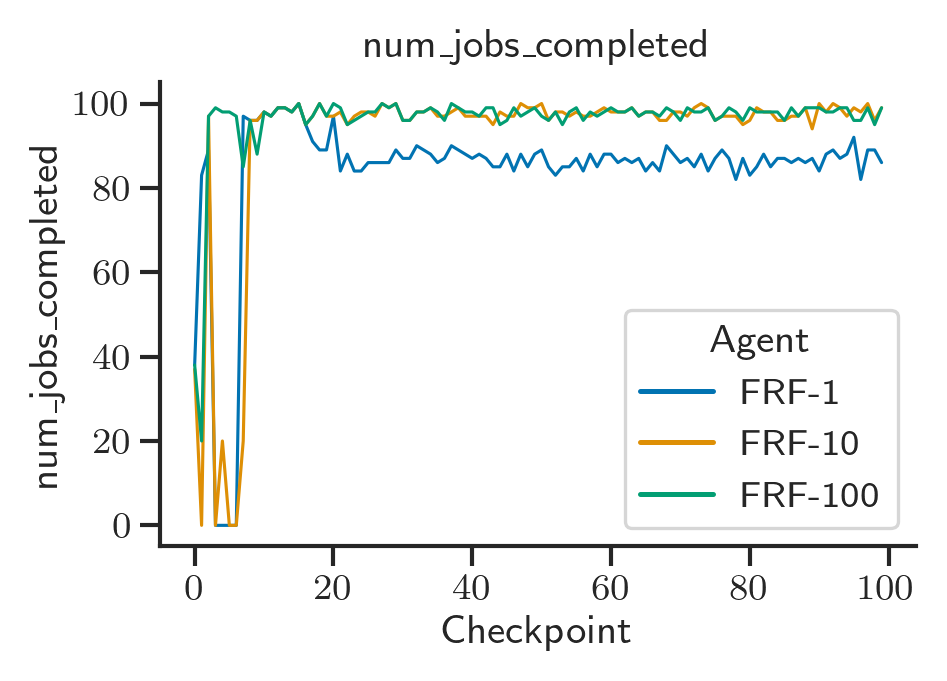

Metric num_jobs_arrived -> Min val: 100.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 100.0 | Max idx: 0 | Max checkpoint: 0


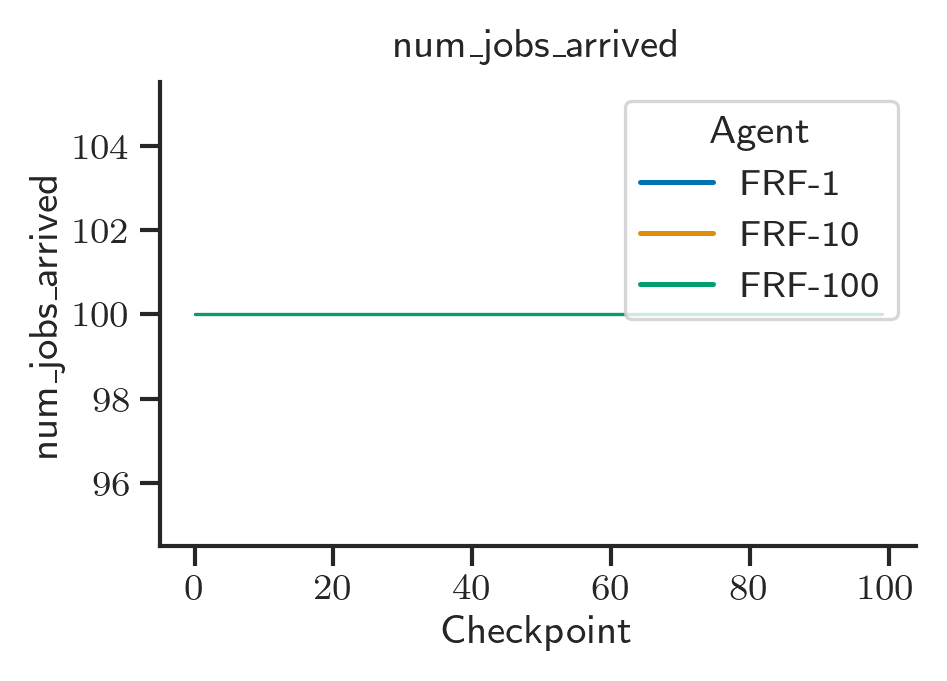

Metric return -> Min val: -100.0 | Min idx: 3 | Min checkpoint: 3 || Max val: -1.0 | Max idx: 215 | Max checkpoint: 15


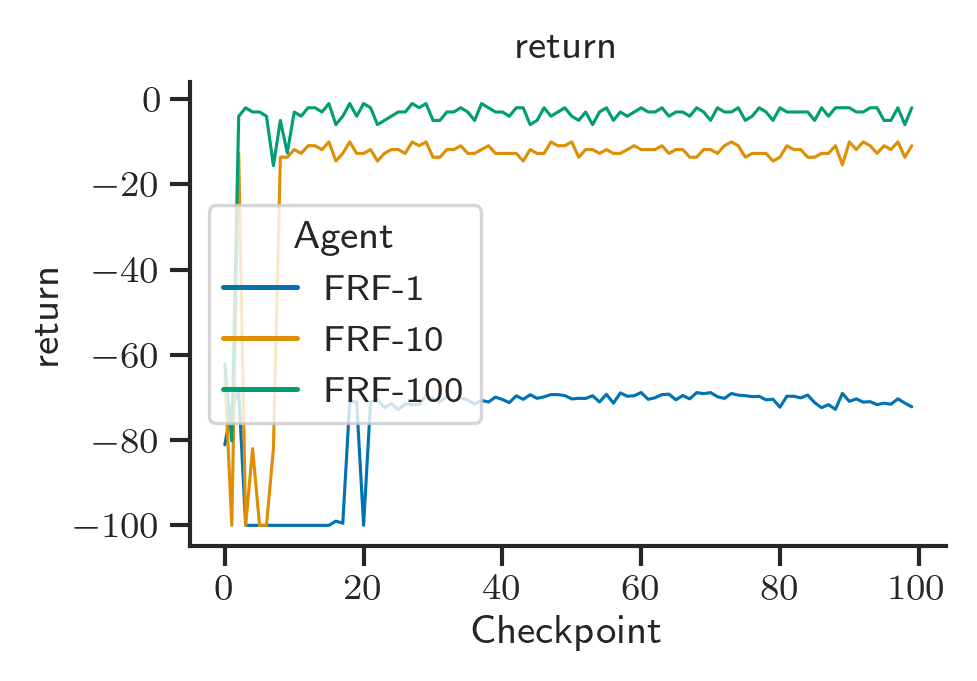

Metric job_computation_overhead_time -> Min val: 4470.800000000002 | Min idx: 193 | Min checkpoint: 1 || Max val: 30733.026804123714 | Max idx: 279 | Max checkpoint: 87


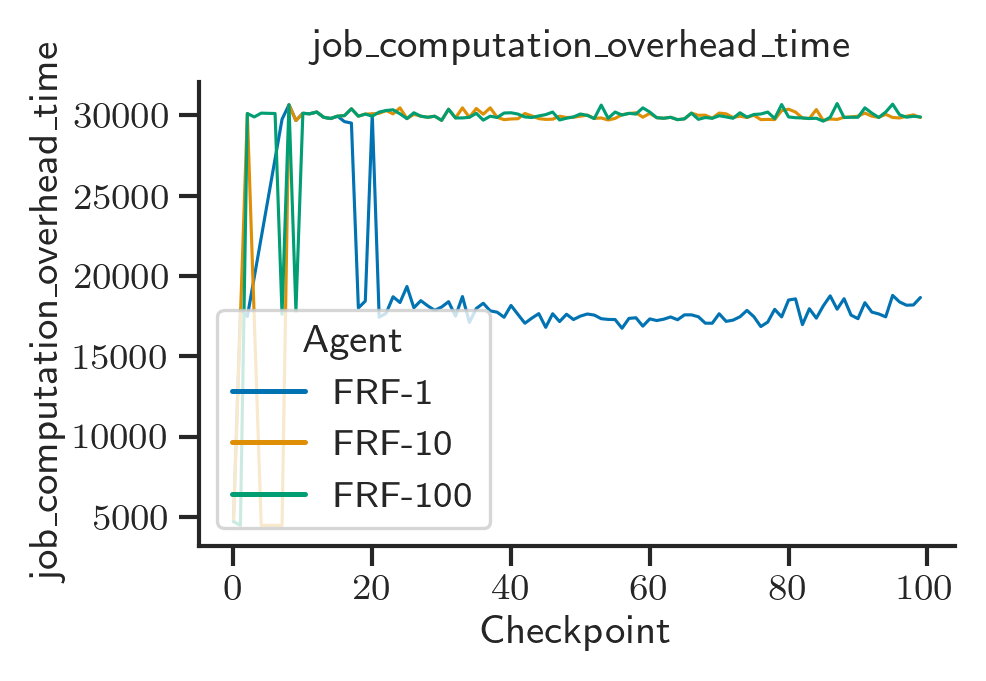

Metric jobs_completed_num_nodes -> Min val: 98.79166666666667 | Min idx: 277 | Min checkpoint: 85 || Max val: 286.3783783783784 | Max idx: 96 | Max checkpoint: 0


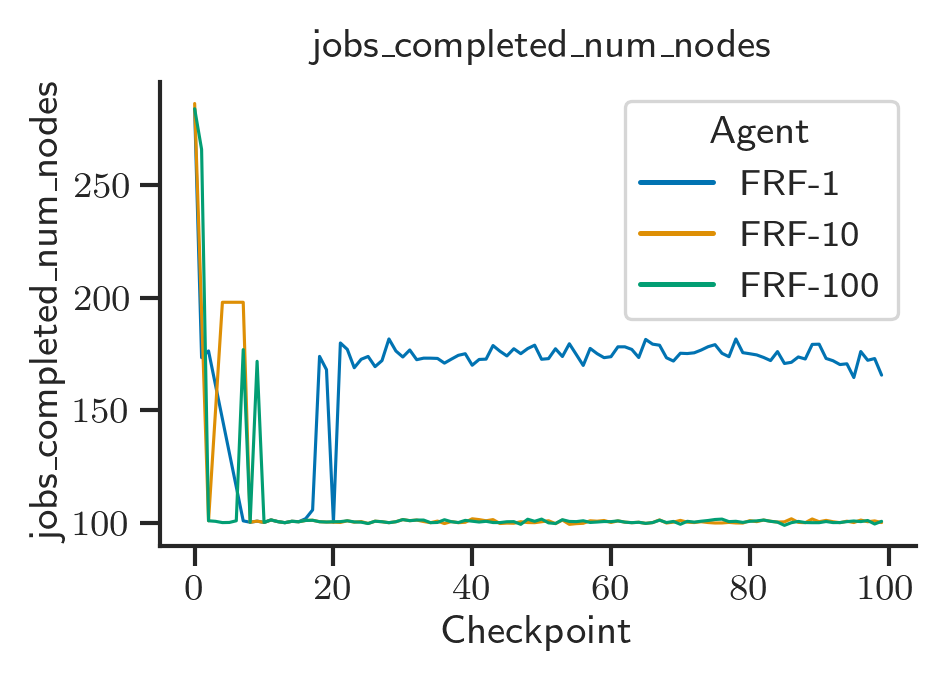

Metric job_completion_time -> Min val: 4470.800000000003 | Min idx: 98 | Min checkpoint: 4 || Max val: 30733.026804123718 | Max idx: 279 | Max checkpoint: 87


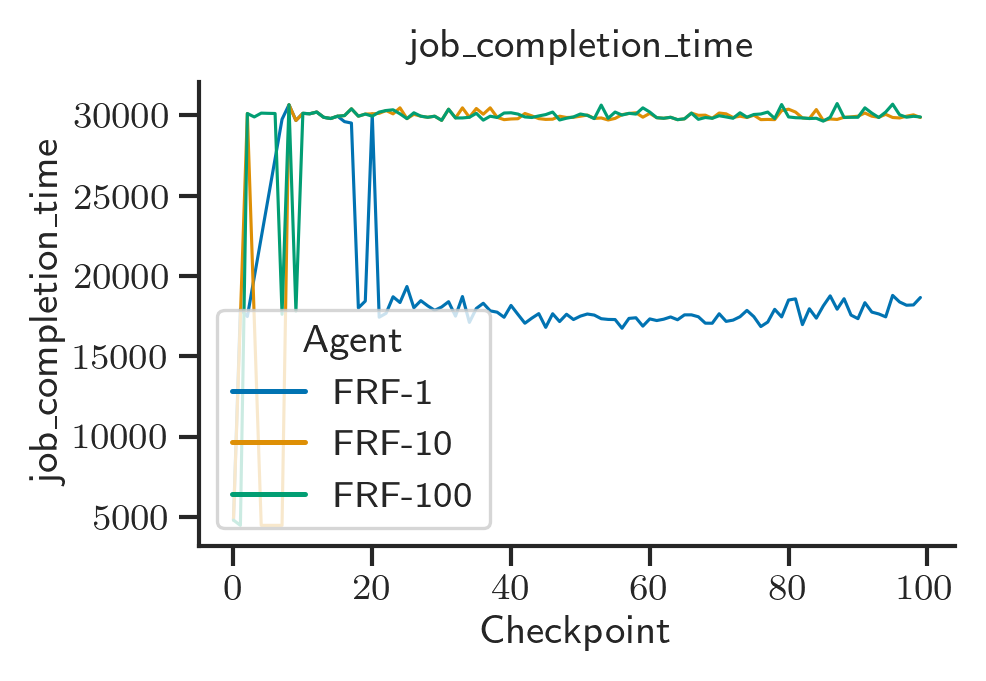

Metric jobs_completed_num_edges -> Min val: 109.95833333333333 | Min idx: 277 | Min checkpoint: 85 || Max val: 2481.3783783783783 | Max idx: 96 | Max checkpoint: 0


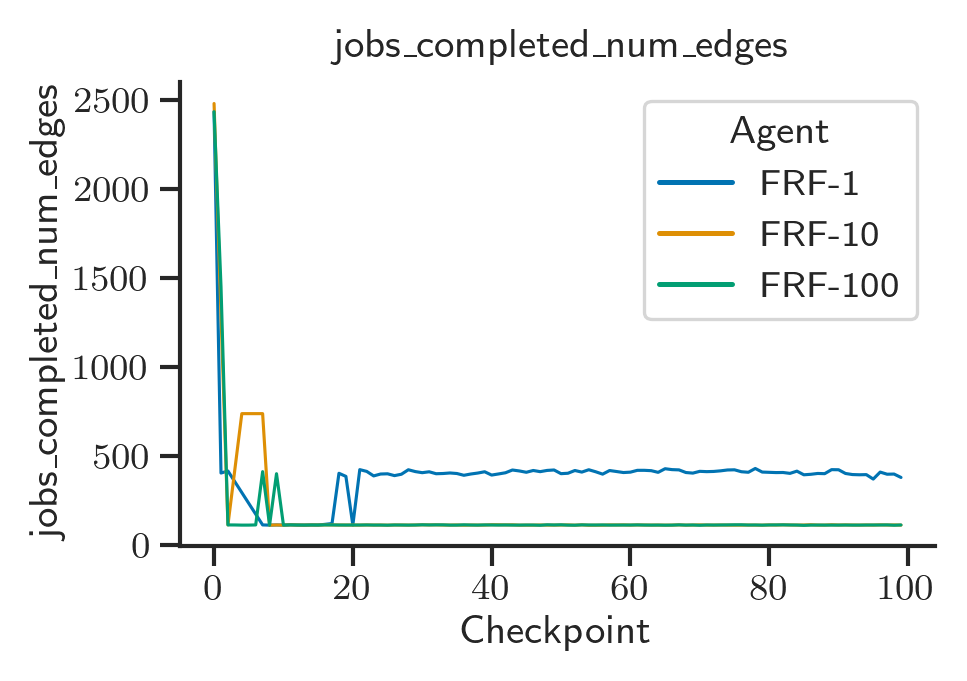

Metric job_communication_overhead_time -> Min val: 4470.800000000002 | Min idx: 193 | Min checkpoint: 1 || Max val: 30733.026804123714 | Max idx: 279 | Max checkpoint: 87


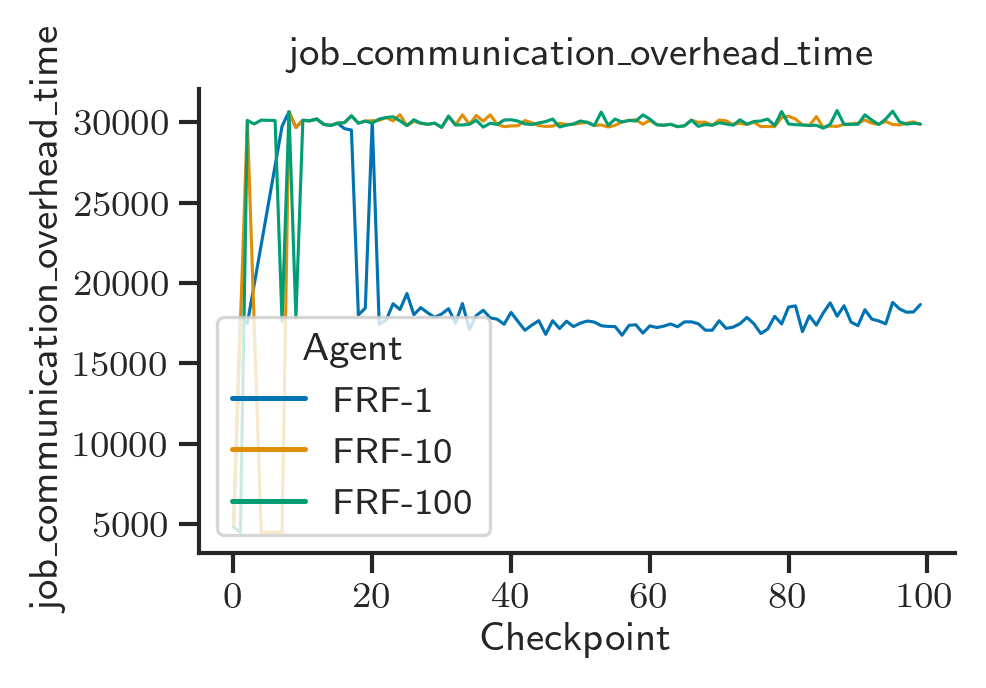

Metric jobs_completed_total_operation_memory_cost -> Min val: 2368446976.0 | Min idx: 98 | Min checkpoint: 4 || Max val: 16603382351.472527 | Max idx: 13 | Max checkpoint: 17


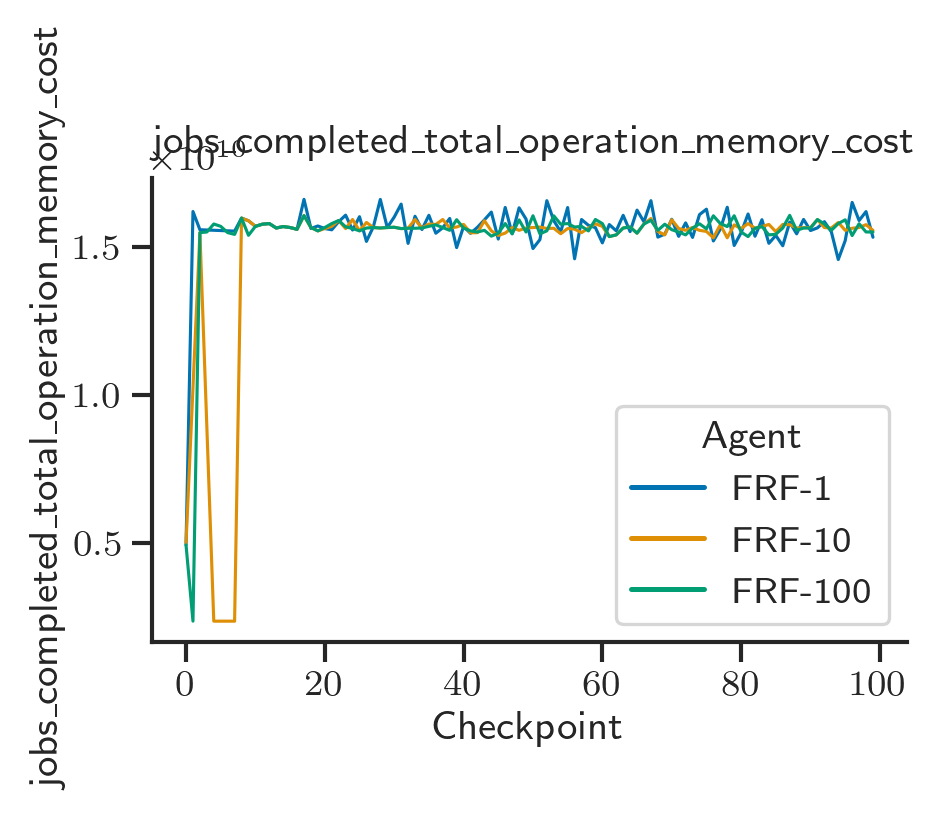

Metric jobs_completed_total_dependency_size -> Min val: 4742728704.0 | Min idx: 98 | Min checkpoint: 4 || Max val: 25334169758.650604 | Max idx: 48 | Max checkpoint: 52


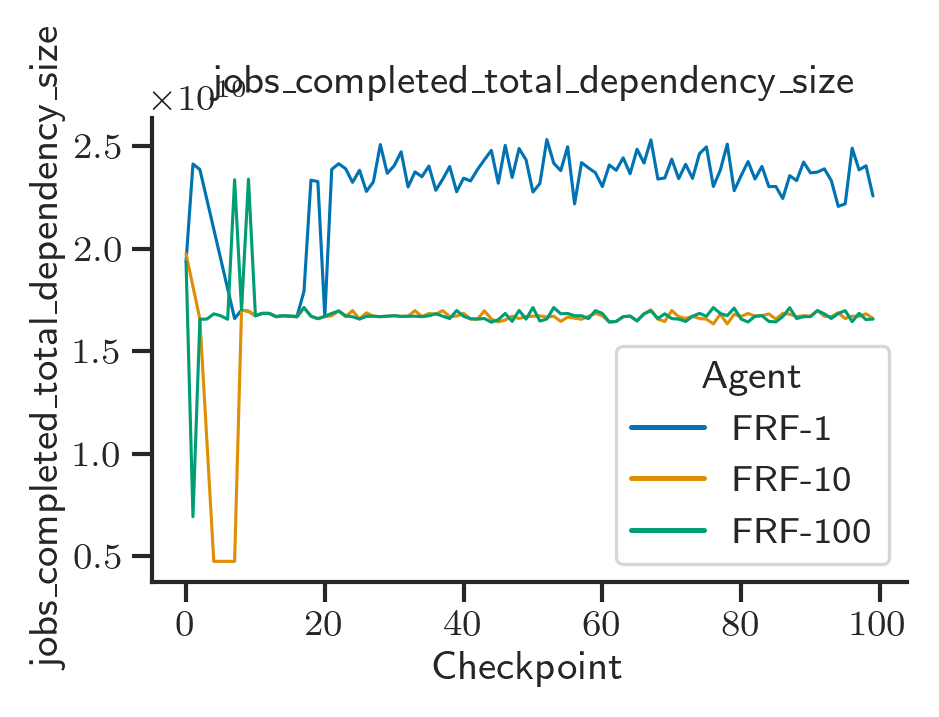

Metric jobs_blocked_total_operation_memory_cost -> Min val: 2368446976.0 | Min idx: 12 | Min checkpoint: 12 || Max val: 30625298760.0 | Max idx: 154 | Max checkpoint: 61


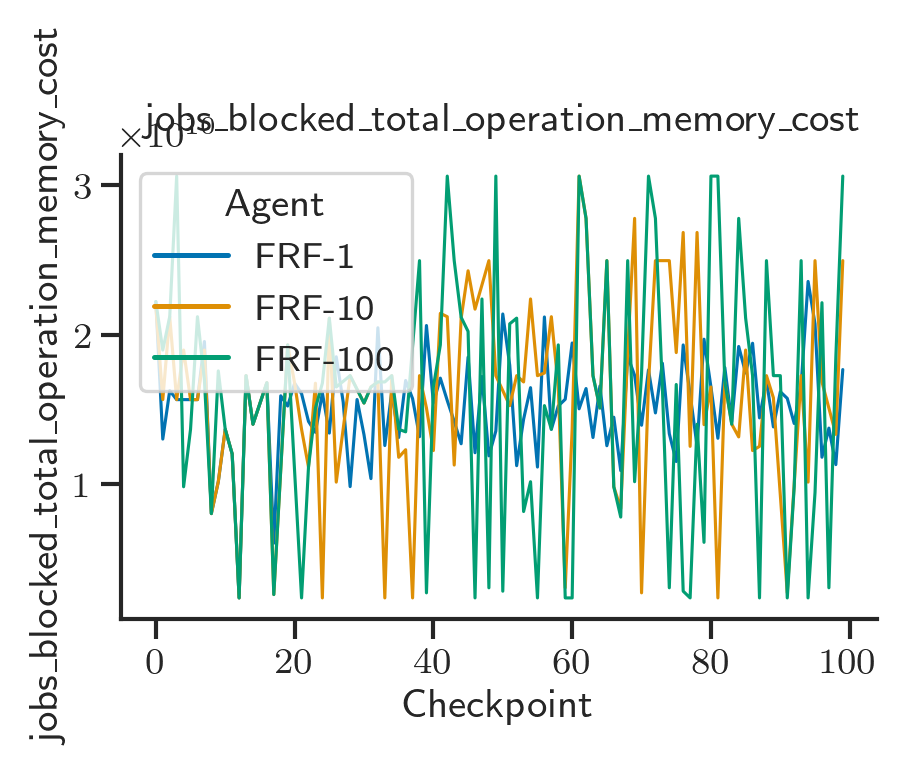

Metric jobs_blocked_num_edges -> Min val: 47.0 | Min idx: 152 | Min checkpoint: 59 || Max val: 159.0 | Max idx: 13 | Max checkpoint: 13


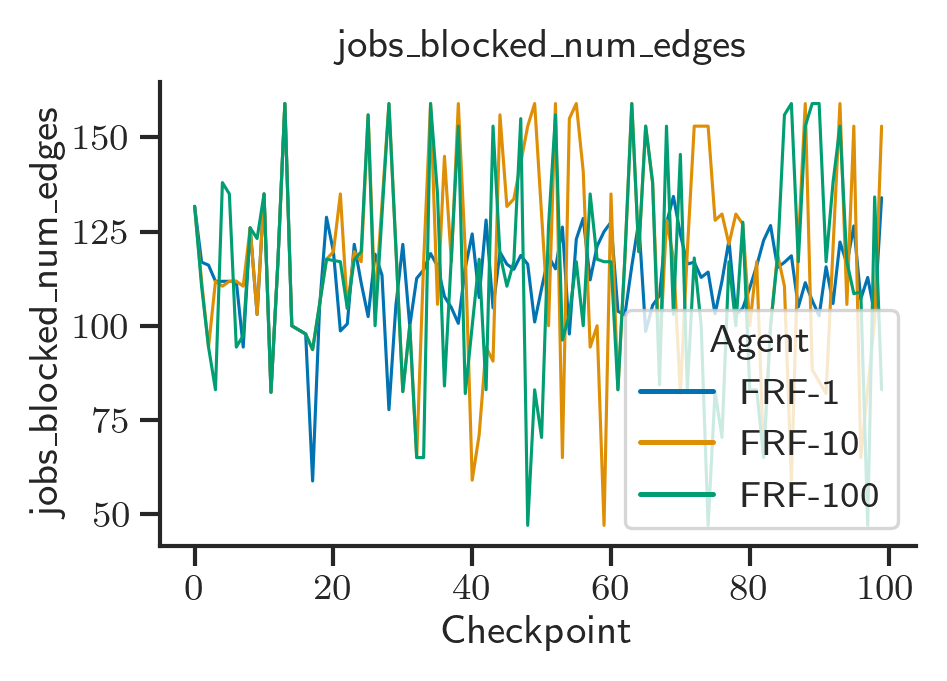

Metric jobs_blocked_total_dependency_size -> Min val: 1027801088.0 | Min idx: 12 | Min checkpoint: 12 || Max val: 29467058184.0 | Max idx: 154 | Max checkpoint: 61


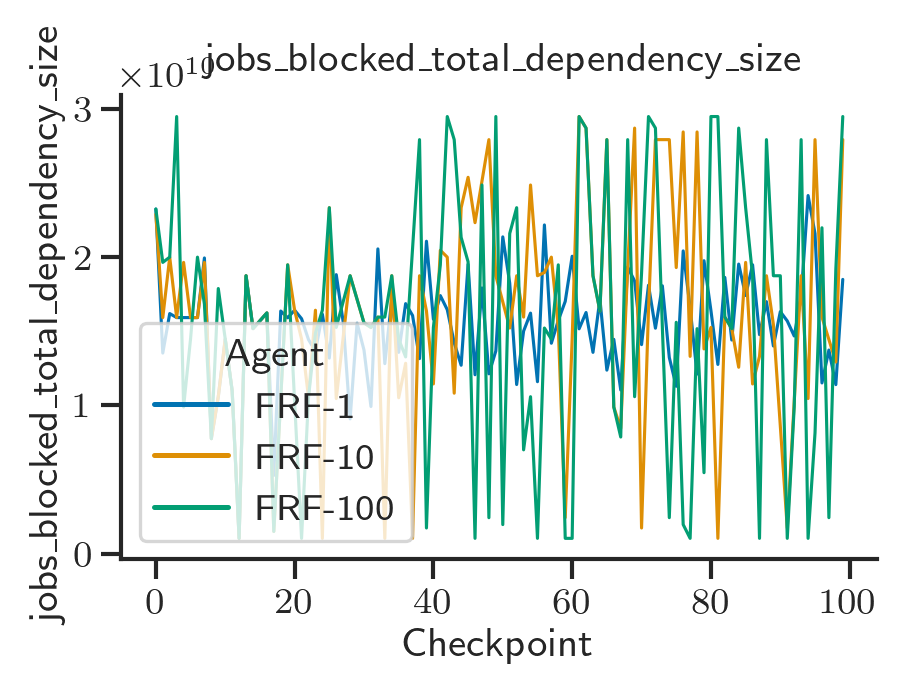

Metric jobs_blocked_num_nodes -> Min val: 46.0 | Min idx: 152 | Min checkpoint: 59 || Max val: 142.0 | Max idx: 13 | Max checkpoint: 13


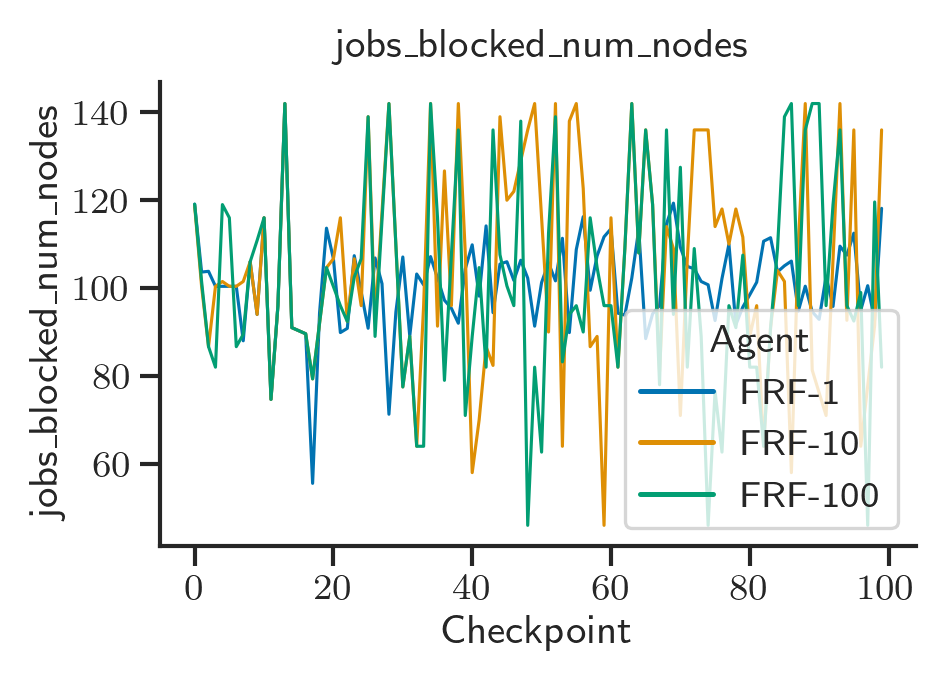



STEP METRICS
Metric mean_num_mounted_workers -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 32.0 | Max idx: 119 | Max checkpoint: 1


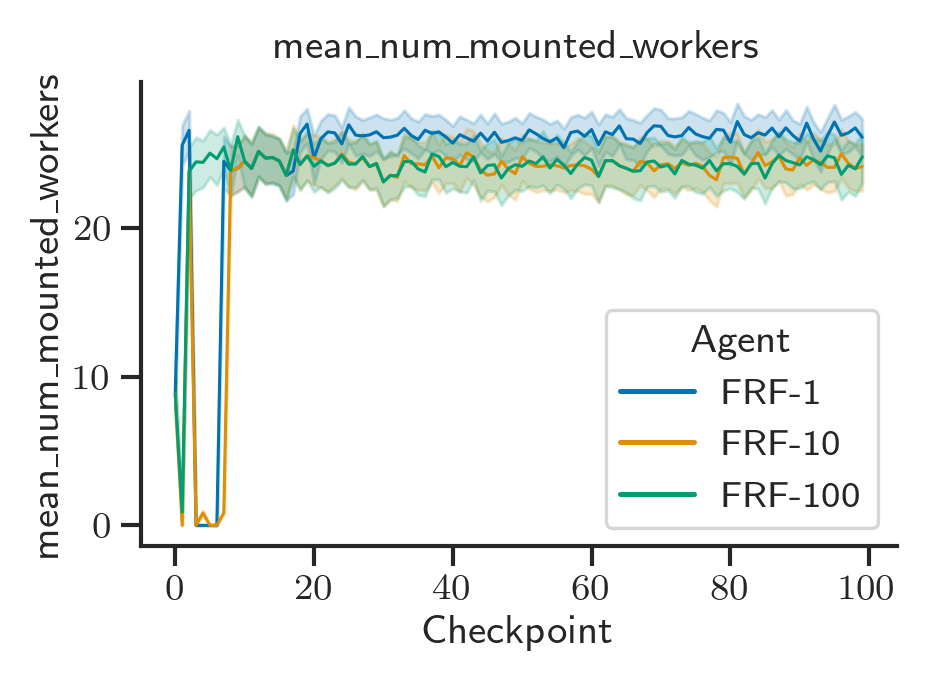

Metric mean_compute_throughput -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 20564882.236627467 | Max idx: 1778 | Max checkpoint: 17


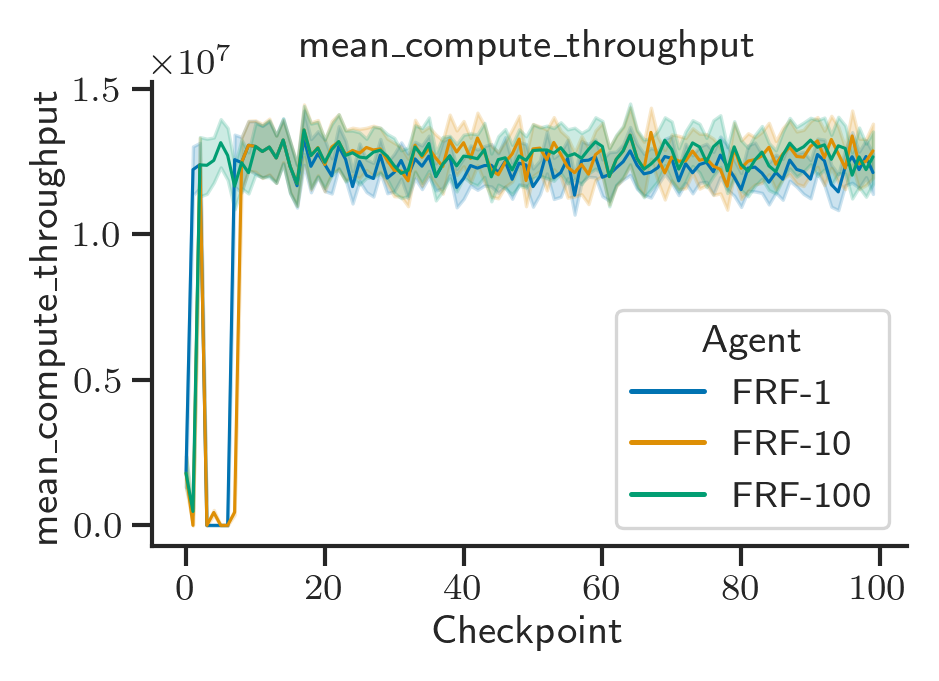

Metric job_queue_length -> Min val: 0 | Min idx: 99 | Min checkpoint: 0 || Max val: 1 | Max idx: 0 | Max checkpoint: 0


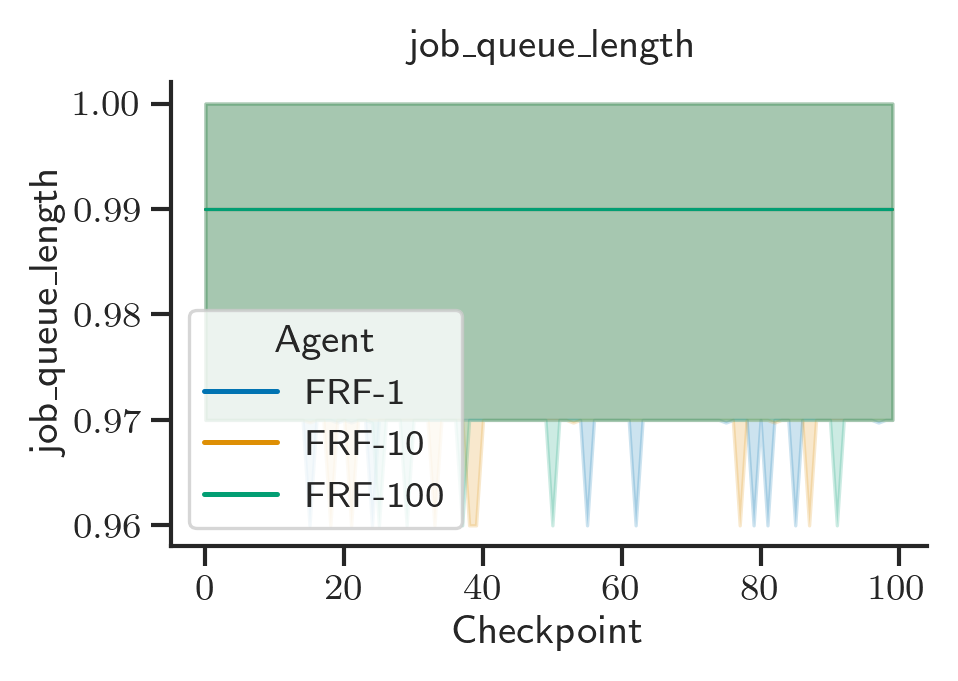

Metric mean_mounted_worker_utilisation_frac -> Min val: 0.7756722198121473 | Min idx: 70 | Min checkpoint: 0 || Max val: 1.0000000000000004 | Max idx: 900 | Max checkpoint: 9


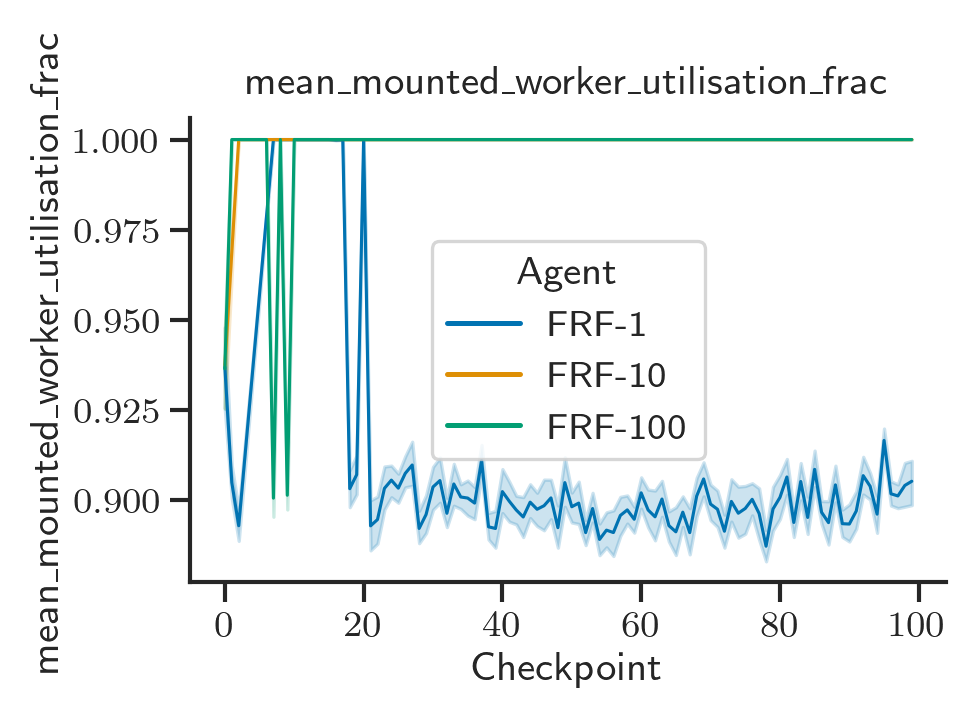

Metric num_jobs_completed -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 32 | Max idx: 11899 | Max checkpoint: 18


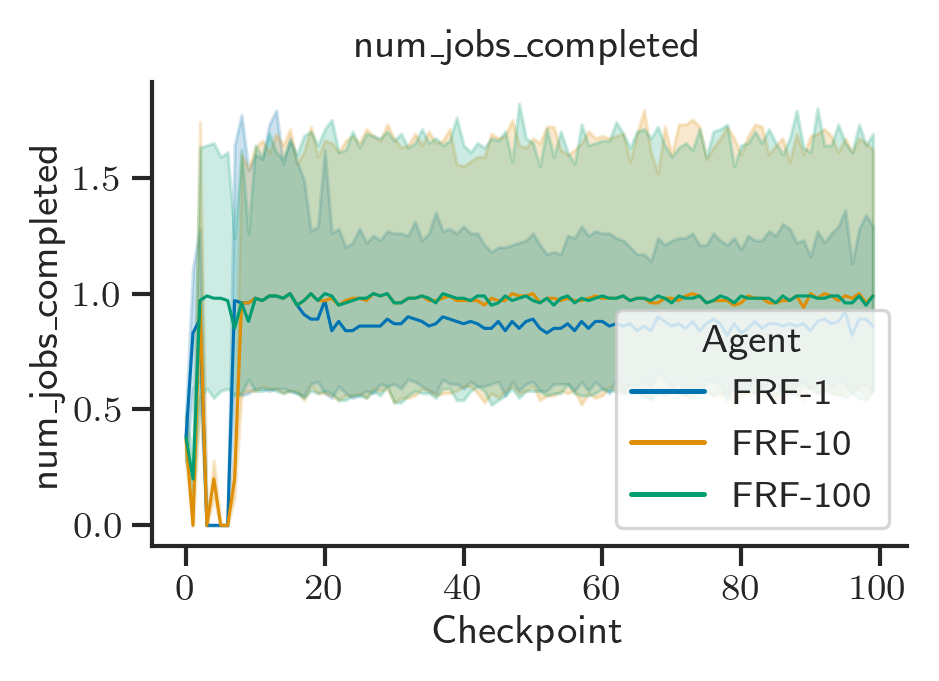

Metric num_jobs_arrived -> Min val: 0 | Min idx: 99 | Min checkpoint: 0 || Max val: 1 | Max idx: 0 | Max checkpoint: 0


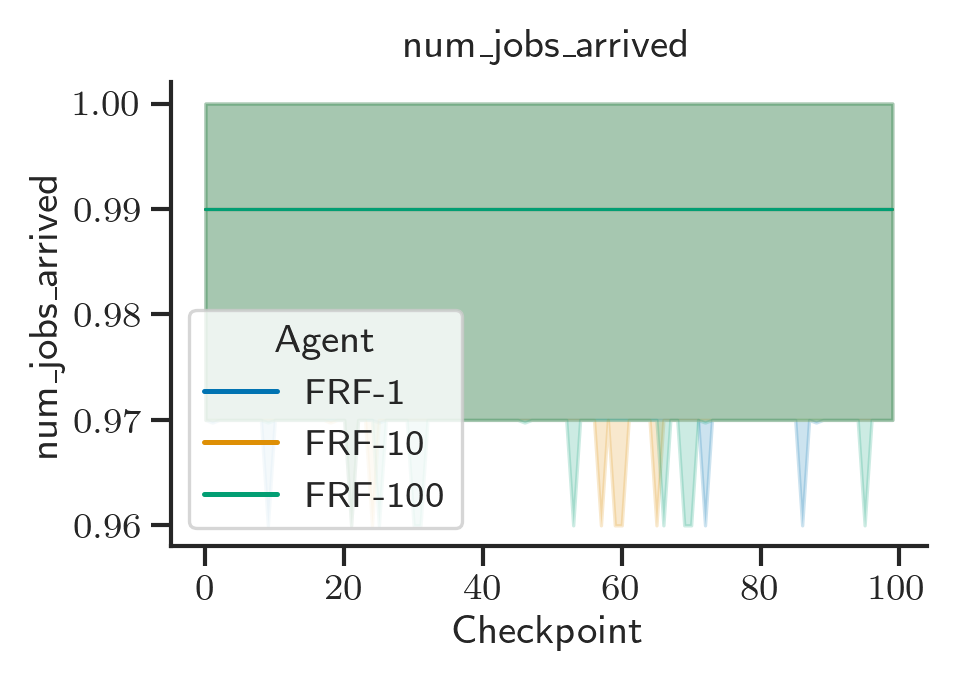

Metric mean_num_jobs_running -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 32.0 | Max idx: 737 | Max checkpoint: 7


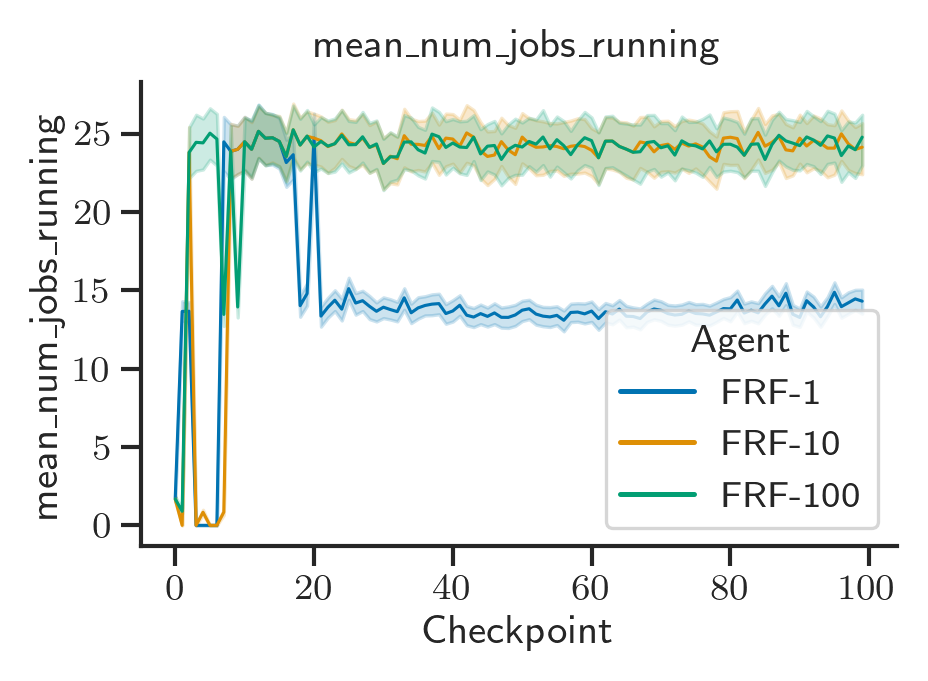

Metric step_end_time -> Min val: 1000.0 | Min idx: 0 | Min checkpoint: 0 || Max val: inf | Max idx: 399 | Max checkpoint: 3


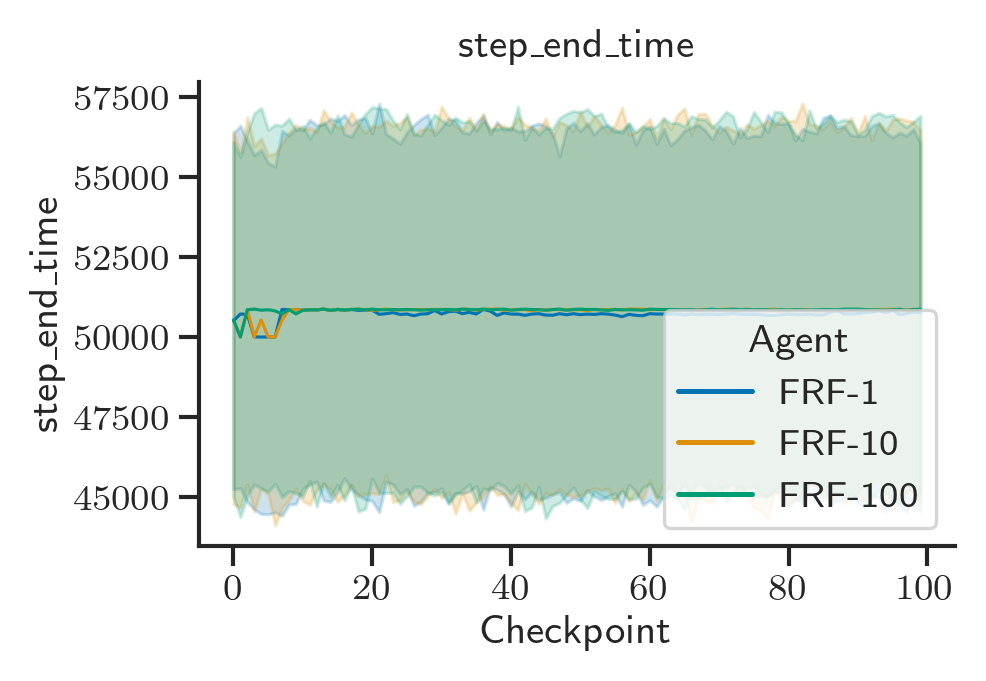

Metric mean_comm_throughput -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 65747231.90107251 | Max idx: 69 | Max checkpoint: 0


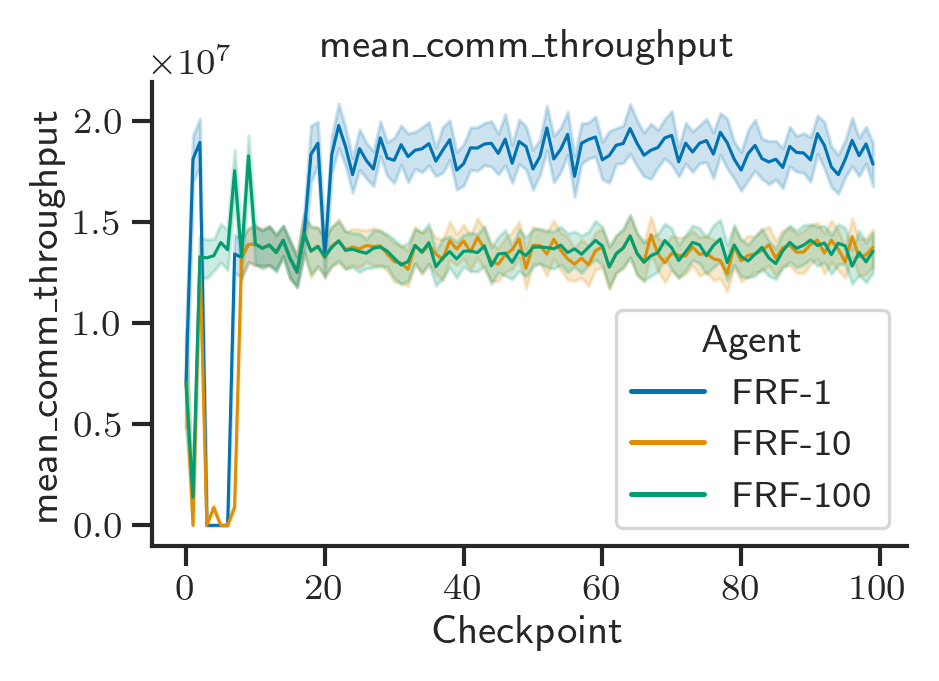

Metric reward -> Min val: -1.0000000000000013 | Min idx: 0 | Min checkpoint: 0 || Max val: -0.001373687961124258 | Max idx: 20002 | Max checkpoint: 0


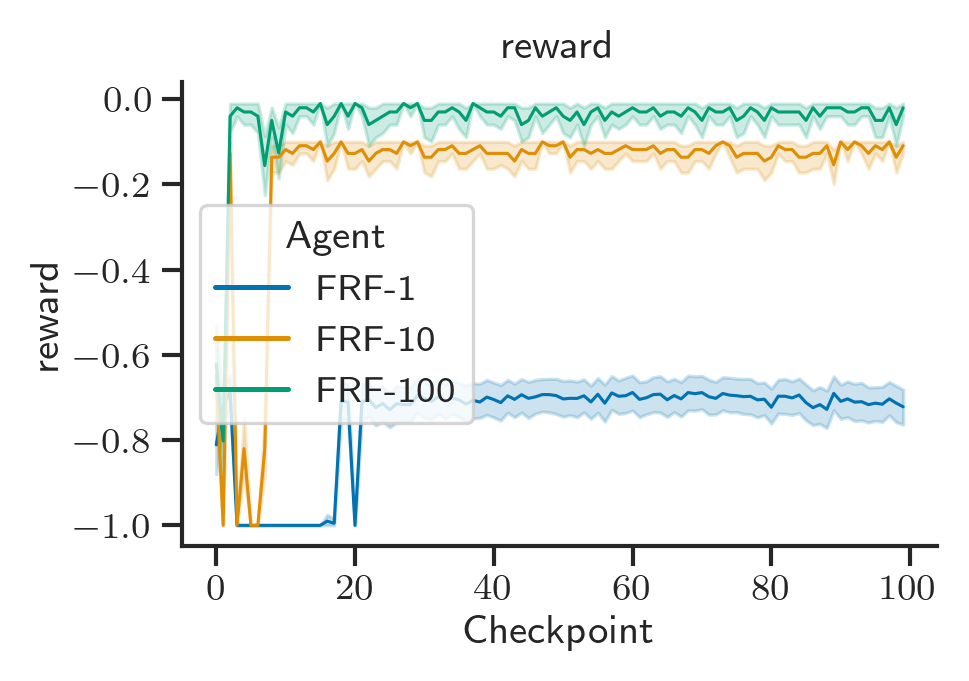

Metric mean_compute_overhead_frac -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 1.0 | Max idx: 0 | Max checkpoint: 0


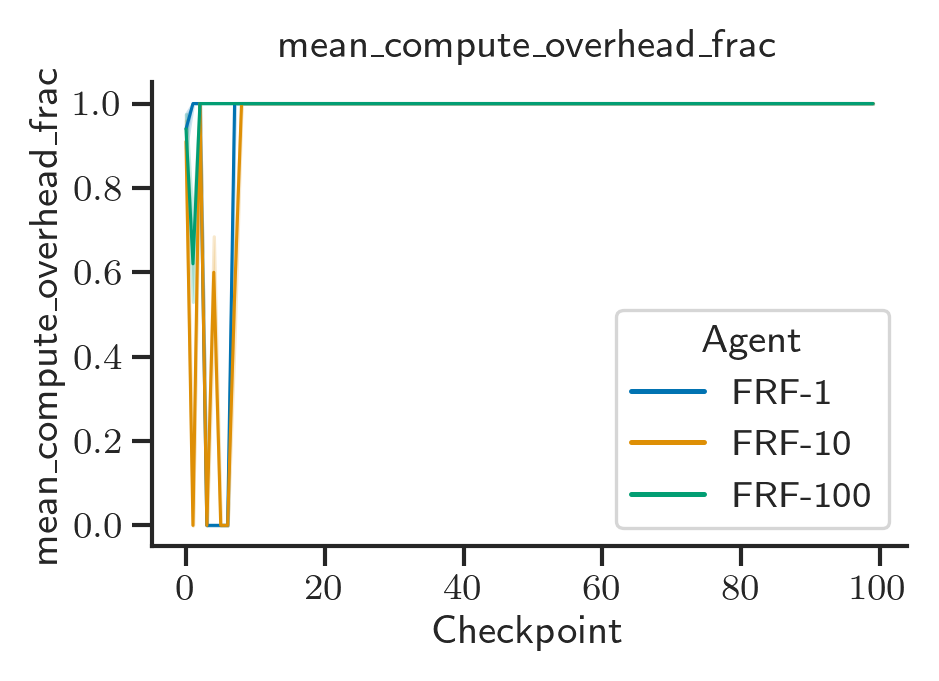

Metric mean_num_mounted_channels -> Min val: 0.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 196.0 | Max idx: 64 | Max checkpoint: 0


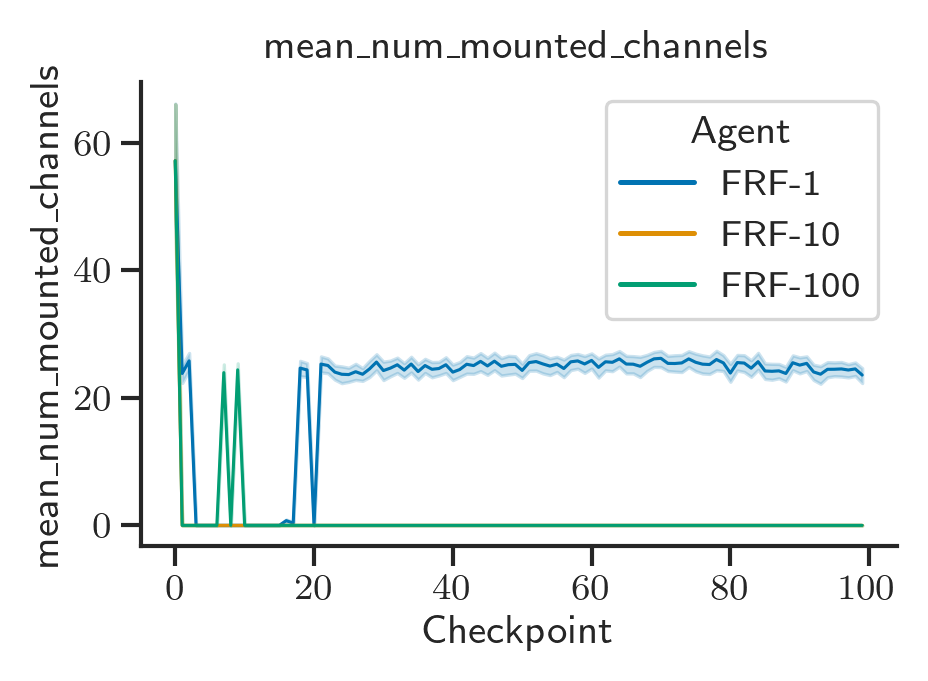

Metric action -> Min val: 0 | Min idx: 6 | Min checkpoint: 0 || Max val: 8 | Max idx: 2 | Max checkpoint: 0


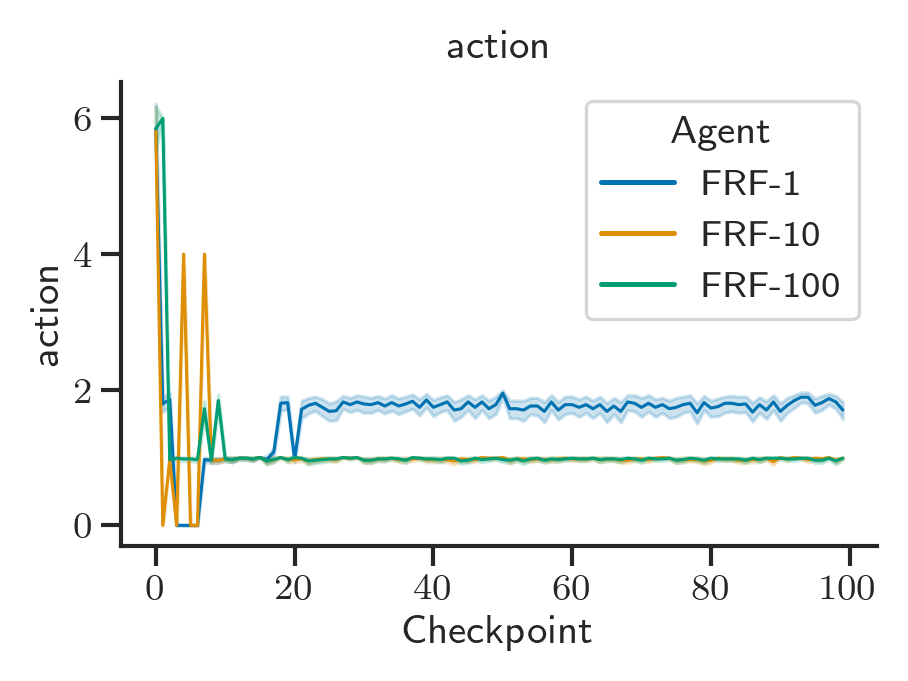

Metric num_jobs_blocked -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 1 | Max idx: 1 | Max checkpoint: 0


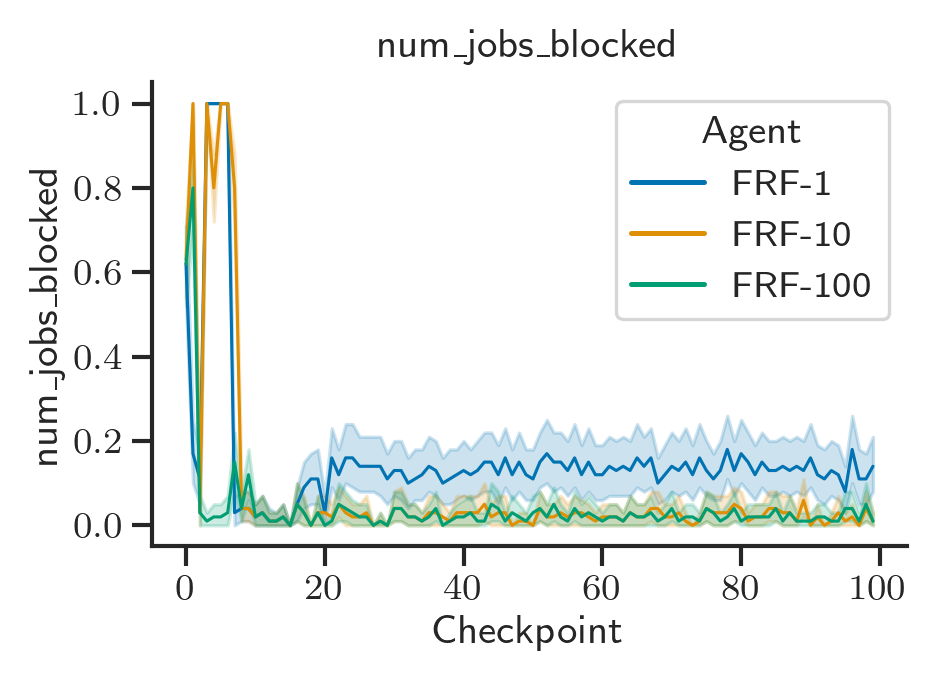

Metric step_start_time -> Min val: 0.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 99000.0 | Max idx: 99 | Max checkpoint: 0


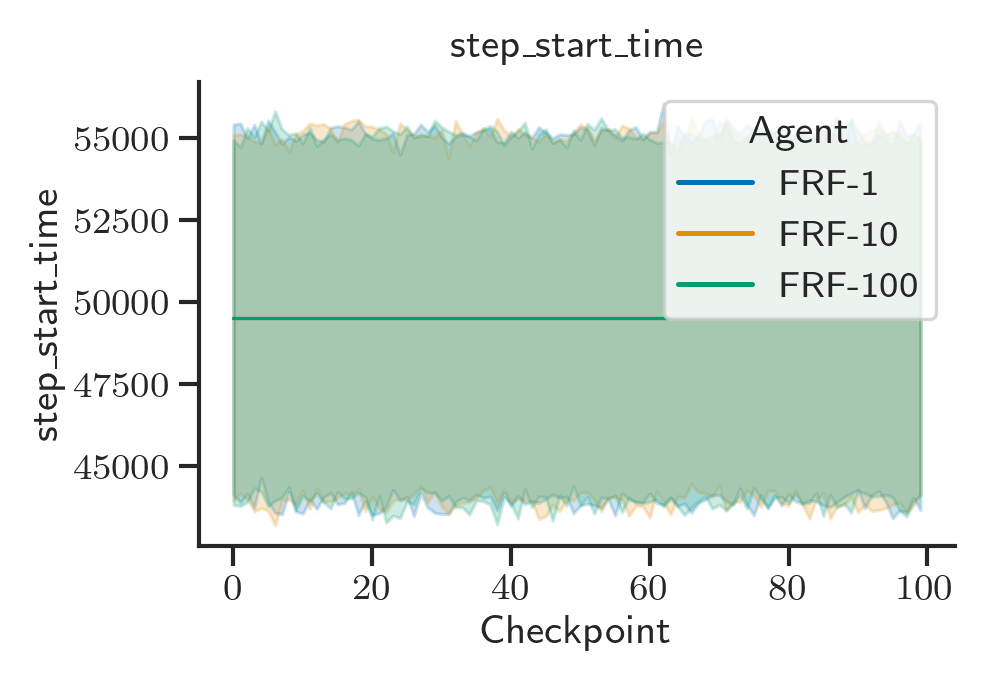

Metric mean_comm_overhead_frac -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 1.0 | Max idx: 0 | Max checkpoint: 0


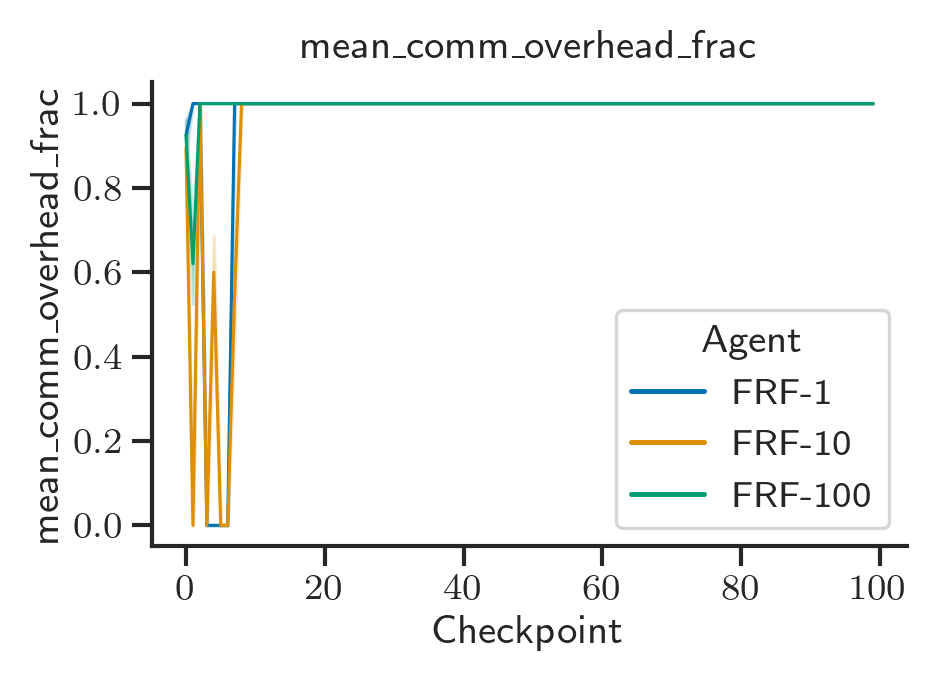

Metric step_counter -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 198 | Max idx: 1599 | Max checkpoint: 15


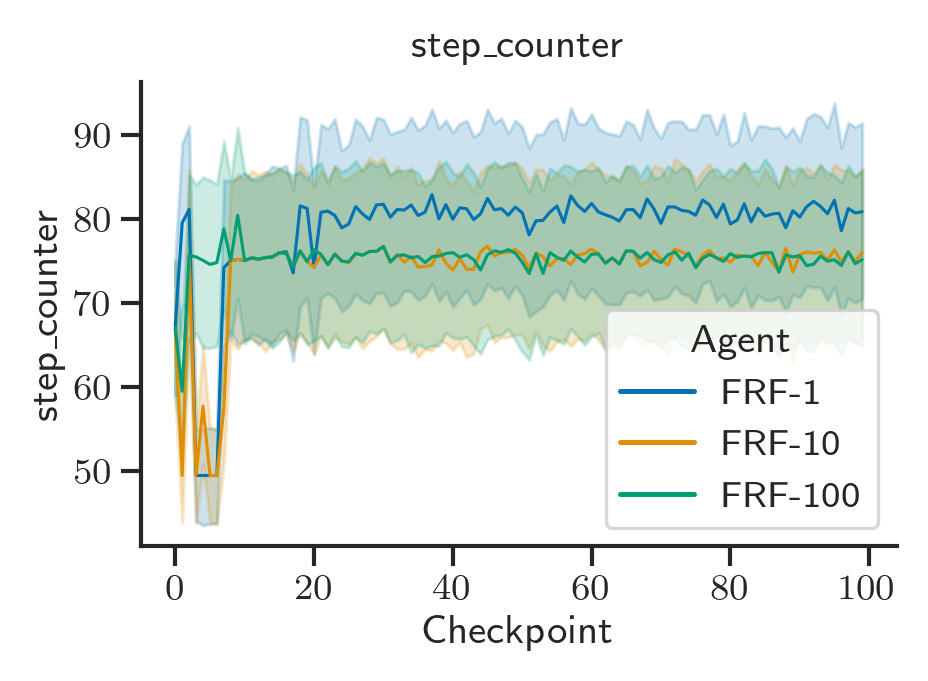

Metric mean_cluster_worker_utilisation_frac -> Min val: 0.031249999999999965 | Min idx: 0 | Min checkpoint: 0 || Max val: 0.9999999999999999 | Max idx: 18589 | Max checkpoint: 85


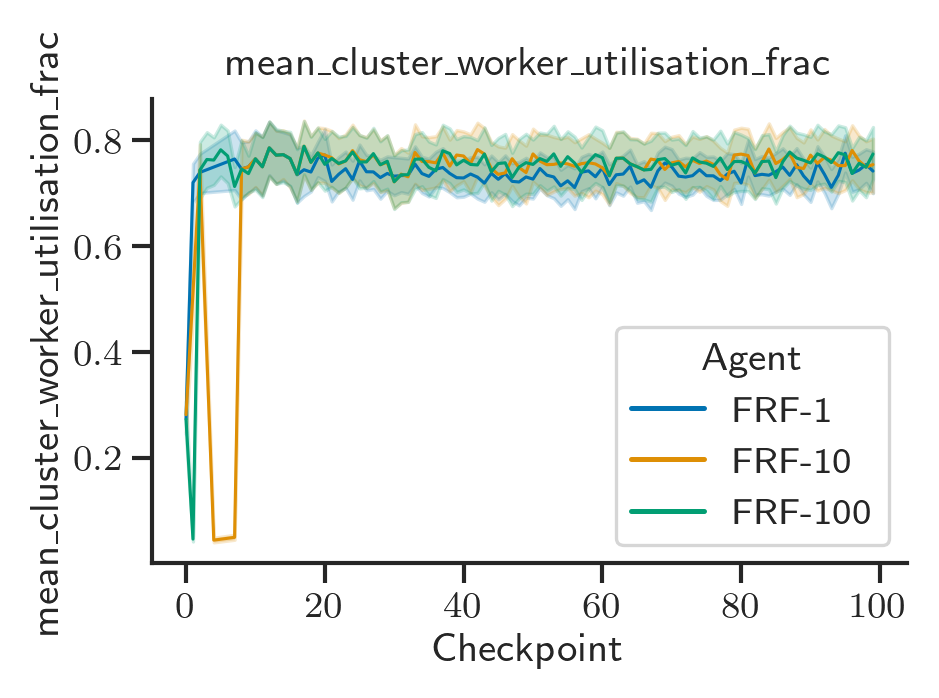

Metric mean_cluster_throughput -> Min val: 0.0 | Min idx: 80 | Min checkpoint: 0 || Max val: 80602234.58229394 | Max idx: 69 | Max checkpoint: 0


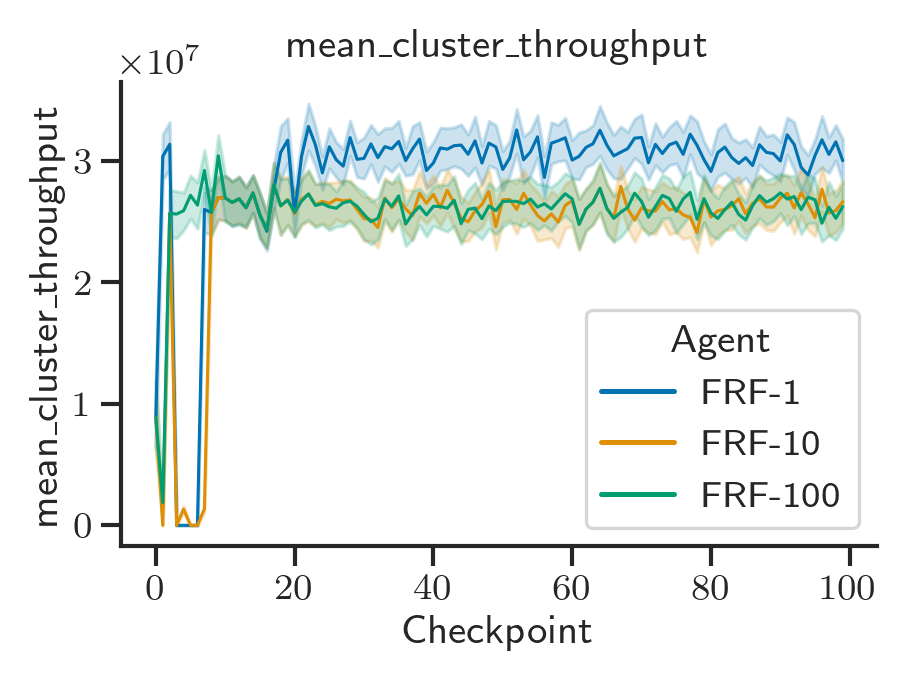

In [20]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    lineplot(df=episode_stats_df, metric=metric)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        lineplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        lineplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)